<a href="https://colab.research.google.com/github/nik-hil-24/scary-faces/blob/main/DCGAN/DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import transforms, datasets

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# device
if torch.cuda.device_count() != 0:
  device = torch.device('cuda:0')

# Data foldder
# folder = '/content/drive/MyDrive/DCGANs/cats'

# Training batch size
batchSize = 128

# Latent vector size
latentSize = 100

# Number of channels
nc = 3

# Image Size
imageSize = 64

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning Rate and hyperparameters
lr = 0.0002
beta1 = 0.5

# Epochs
epochs = 100

# Transforms
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(imageSize)])

In [5]:
# Datatset
dataset = datasets.LFWPeople(root = '/content', split = 'train', transform = TRANSFORM, download = True)
trainLoader = DataLoader(dataset = dataset, batch_size = batchSize, shuffle = True)

images, classes = next(iter(trainLoader))

Files already downloaded and verified


In [6]:
# class Dataset():
#     data = []
#     def readImages(self, folder):
#         for files in os.listdir(folder):
#           try:
#             image_path = os.path.join(folder, files)
#             image = cv2.imread(image_path)
#             if image is not None:
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                 # image = cv2.resize(image, (64, 64))
#                 self.data.append(np.array(image))
#           except Exception as e:
#             print('Error in reading data')
#         self.data = torch.tensor(self.data, dtype = torch.float32).view(-1, 3, 64, 64)
#         end_pt = int(len(self.data)/128)*128
#         self.data = self.data[:end_pt]
#         np.save('data.npy', self.data/255)

# dataReader = Dataset()
# dataReader.readImages(folder)

In [7]:
# data = np.load('data.npy')
# data = torch.tensor(data)

# **Model**

In [8]:
def weightInit(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [9]:
# this is correct
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(latentSize, ngf*8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),

        # 512x4x4
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),

        # 256x8x8
        nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),

        # 128x16x16
        nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        # 64x32x32
        nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias = False),
        nn.Tanh()
        # 3x64x64
    )

  def forward(self, x):
    return self.main(x)

generator = Generator().to(device)
generator.apply(weightInit)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [10]:
# this is correct
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3, ndf, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2),

        # block 1
        nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, True),

        # block 2
        nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2, True),

        # block 3
        nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2, True),

        # block final
        nn.Conv2d(ndf*8, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.main(x)

discriminator = Discriminator().to(device)
discriminator.apply(weightInit)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## **Train**

In [15]:
def inference(gen, epoch, n = 2):
    if '/content/drive/MyDrive/inference/gan' not in os.listdir('/content/drive/MyDrive/inference'):
        try:
            os.mkdir('/content/drive/MyDrive/inference/gan')
        except:
            pass

    for i in range(n):
        x = torch.randn(1, 100, 1, 1).to(device)
        y = gen(x)
        y = y.cpu()
        save_image(y.view(3,64,64), f"/content/drive/MyDrive/inference/gan/generated_epoch_{epoch}_iter_{i+1}.png")

In [12]:
criterion = nn.BCELoss()

noise = torch.randn(32, latentSize, 1, 1)

optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr = lr,  betas = (beta1, 0.999))

In [13]:
errorD = []
errorG = []

discriminator.train()
generator.train()

for epoch in range(epochs):
    print(f'[{epoch+1}/{epochs}] Epochs')
    loop = tqdm(enumerate(trainLoader))
    # for i in range(0, len(data), batchSize):
    for batch_idx, (x, _) in loop:
        X = x.to(device)
        b, _, _, _ = X.shape
        noise = torch.randn(b, latentSize, 1, 1).to(device)
        realLabels = torch.ones(b).to(device)
        fakeLabels = torch.zeros(b).to(device)

        # Train Discriminator
        discriminator.zero_grad()
        fake = generator(noise)
        output = discriminator(X).view(-1).to(device)
        errR = criterion(output, realLabels)

        fake = generator(noise)
        output = discriminator(fake).view(-1).to(device)
        errF = criterion(output, fakeLabels)

        errD = errR + errF
        errD.backward(retain_graph = True)
        optimizerD.step()

        # Train Generator
        generator.zero_grad()
        noise = torch.randn(b, latentSize, 1, 1).to(device)
        fake = generator(noise)
        realLabels = torch.ones(b).to(device)
        output = discriminator(fake).view(-1).to(device)
        errG = criterion(output, realLabels)

        errG.backward()
        optimizerG.step()

        errorD.append(errD.item())
        errorG.append(errG.item())
        loop.set_postfix(lossD = errD.item(), lossG = errG.item())

    if (epoch+1)%10 == 0:
        inference(generator, epoch)

[1/100] Epochs


75it [00:36,  2.03it/s, lossD=0.0536, lossG=3.64]


[2/100] Epochs


75it [00:28,  2.60it/s, lossD=0.862, lossG=1.89]


[3/100] Epochs


75it [00:28,  2.62it/s, lossD=1.4, lossG=5.59]


[4/100] Epochs


75it [00:29,  2.57it/s, lossD=0.279, lossG=5.07]


[5/100] Epochs


75it [00:29,  2.54it/s, lossD=0.509, lossG=5.09]


[6/100] Epochs


75it [00:29,  2.52it/s, lossD=0.739, lossG=5.52]


[7/100] Epochs


75it [00:28,  2.63it/s, lossD=0.429, lossG=4.77]


[8/100] Epochs


75it [00:28,  2.60it/s, lossD=0.624, lossG=4.13]


[9/100] Epochs


75it [00:28,  2.62it/s, lossD=0.457, lossG=3.9]


[10/100] Epochs


75it [00:28,  2.60it/s, lossD=0.568, lossG=4.36]


[11/100] Epochs


75it [00:28,  2.59it/s, lossD=0.895, lossG=6.31]


[12/100] Epochs


75it [00:28,  2.61it/s, lossD=0.533, lossG=5.32]


[13/100] Epochs


75it [00:28,  2.61it/s, lossD=0.496, lossG=5.4]


[14/100] Epochs


75it [00:28,  2.59it/s, lossD=1.36, lossG=7.6]


[15/100] Epochs


75it [00:28,  2.61it/s, lossD=0.307, lossG=3.39]


[16/100] Epochs


75it [00:29,  2.56it/s, lossD=0.518, lossG=2.86]


[17/100] Epochs


75it [00:28,  2.62it/s, lossD=0.412, lossG=5.6]


[18/100] Epochs


75it [00:28,  2.61it/s, lossD=0.241, lossG=4.99]


[19/100] Epochs


75it [00:28,  2.60it/s, lossD=0.293, lossG=4.12]


[20/100] Epochs


75it [00:28,  2.60it/s, lossD=0.431, lossG=4.16]


[21/100] Epochs


75it [00:29,  2.58it/s, lossD=0.52, lossG=3.9]


[22/100] Epochs


75it [00:29,  2.57it/s, lossD=0.202, lossG=4.85]


[23/100] Epochs


75it [00:28,  2.60it/s, lossD=0.255, lossG=4.5]


[24/100] Epochs


75it [00:28,  2.60it/s, lossD=0.29, lossG=3.21]


[25/100] Epochs


75it [00:29,  2.58it/s, lossD=0.984, lossG=4.37]


[26/100] Epochs


75it [00:28,  2.59it/s, lossD=0.396, lossG=3.88]


[27/100] Epochs


75it [00:28,  2.59it/s, lossD=0.229, lossG=4.77]


[28/100] Epochs


75it [00:29,  2.58it/s, lossD=0.453, lossG=6.03]


[29/100] Epochs


75it [00:29,  2.57it/s, lossD=0.605, lossG=2.56]


[30/100] Epochs


75it [00:28,  2.60it/s, lossD=0.288, lossG=3.08]


[31/100] Epochs


75it [00:29,  2.58it/s, lossD=0.41, lossG=5.32]


[32/100] Epochs


75it [00:28,  2.63it/s, lossD=0.198, lossG=4.16]


[33/100] Epochs


75it [00:29,  2.55it/s, lossD=0.11, lossG=4.62]


[34/100] Epochs


75it [00:29,  2.53it/s, lossD=0.183, lossG=2.89]


[35/100] Epochs


75it [00:29,  2.59it/s, lossD=0.295, lossG=3.8]


[36/100] Epochs


75it [00:29,  2.58it/s, lossD=2.05, lossG=0.561]


[37/100] Epochs


75it [00:29,  2.59it/s, lossD=0.416, lossG=3.32]


[38/100] Epochs


75it [00:28,  2.59it/s, lossD=0.171, lossG=3.25]


[39/100] Epochs


75it [00:29,  2.59it/s, lossD=0.273, lossG=3.23]


[40/100] Epochs


75it [00:28,  2.59it/s, lossD=0.313, lossG=4.89]


[41/100] Epochs


75it [00:29,  2.58it/s, lossD=0.791, lossG=8.76]


[42/100] Epochs


75it [00:28,  2.59it/s, lossD=0.292, lossG=4.54]


[43/100] Epochs


75it [00:28,  2.59it/s, lossD=0.497, lossG=5.26]


[44/100] Epochs


75it [00:30,  2.49it/s, lossD=0.164, lossG=4.07]


[45/100] Epochs


75it [00:29,  2.58it/s, lossD=0.513, lossG=7.64]


[46/100] Epochs


75it [00:28,  2.59it/s, lossD=0.163, lossG=4.98]


[47/100] Epochs


75it [00:29,  2.56it/s, lossD=0.866, lossG=3.14]


[48/100] Epochs


75it [00:28,  2.60it/s, lossD=0.263, lossG=6.42]


[49/100] Epochs


75it [00:28,  2.60it/s, lossD=0.478, lossG=2.48]


[50/100] Epochs


75it [00:28,  2.61it/s, lossD=0.326, lossG=3.07]


[51/100] Epochs


75it [00:28,  2.60it/s, lossD=0.511, lossG=7.96]


[52/100] Epochs


75it [00:28,  2.60it/s, lossD=0.691, lossG=0.417]


[53/100] Epochs


75it [00:29,  2.54it/s, lossD=2.19, lossG=11.6]


[54/100] Epochs


75it [00:28,  2.63it/s, lossD=0.168, lossG=5.44]


[55/100] Epochs


75it [00:28,  2.62it/s, lossD=2.4, lossG=4.05]


[56/100] Epochs


75it [00:28,  2.61it/s, lossD=0.285, lossG=4.47]


[57/100] Epochs


75it [00:28,  2.62it/s, lossD=0.262, lossG=3.13]


[58/100] Epochs


75it [00:28,  2.59it/s, lossD=0.609, lossG=8.87]


[59/100] Epochs


75it [00:28,  2.60it/s, lossD=0.431, lossG=4.29]


[60/100] Epochs


75it [00:28,  2.62it/s, lossD=1.4, lossG=5.46]


[61/100] Epochs


75it [00:28,  2.62it/s, lossD=0.214, lossG=4.99]


[62/100] Epochs


75it [00:28,  2.62it/s, lossD=0.205, lossG=4.22]


[63/100] Epochs


75it [00:29,  2.54it/s, lossD=0.259, lossG=5.42]


[64/100] Epochs


75it [00:28,  2.60it/s, lossD=0.111, lossG=5.43]


[65/100] Epochs


75it [00:28,  2.60it/s, lossD=0.426, lossG=5.79]


[66/100] Epochs


75it [00:28,  2.62it/s, lossD=0.252, lossG=5.46]


[67/100] Epochs


75it [00:28,  2.63it/s, lossD=0.28, lossG=8.68]


[68/100] Epochs


75it [00:28,  2.62it/s, lossD=0.267, lossG=5.08]


[69/100] Epochs


75it [00:28,  2.62it/s, lossD=0.186, lossG=5.51]


[70/100] Epochs


75it [00:28,  2.62it/s, lossD=0.182, lossG=3.82]


[71/100] Epochs


75it [00:28,  2.62it/s, lossD=0.494, lossG=2.24]


[72/100] Epochs


75it [00:29,  2.51it/s, lossD=0.252, lossG=4.15]


[73/100] Epochs


75it [00:28,  2.59it/s, lossD=0.239, lossG=2.33]


[74/100] Epochs


75it [00:28,  2.60it/s, lossD=0.127, lossG=5.9]


[75/100] Epochs


75it [00:28,  2.61it/s, lossD=0.155, lossG=3.53]


[76/100] Epochs


75it [00:28,  2.63it/s, lossD=1.12, lossG=12]


[77/100] Epochs


75it [00:28,  2.62it/s, lossD=0.436, lossG=3.83]


[78/100] Epochs


75it [00:28,  2.62it/s, lossD=0.108, lossG=5.13]


[79/100] Epochs


75it [00:28,  2.63it/s, lossD=0.16, lossG=5.11]


[80/100] Epochs


75it [00:28,  2.61it/s, lossD=0.157, lossG=3.51]


[81/100] Epochs


75it [00:29,  2.52it/s, lossD=0.255, lossG=3.54]


[82/100] Epochs


75it [00:28,  2.62it/s, lossD=0.0834, lossG=5.01]


[83/100] Epochs


75it [00:28,  2.60it/s, lossD=0.181, lossG=5.47]


[84/100] Epochs


75it [00:28,  2.61it/s, lossD=0.197, lossG=5.2]


[85/100] Epochs


75it [00:28,  2.59it/s, lossD=0.139, lossG=4.08]


[86/100] Epochs


75it [00:29,  2.58it/s, lossD=0.0429, lossG=5.51]


[87/100] Epochs


75it [00:29,  2.57it/s, lossD=0.0911, lossG=1.54]


[88/100] Epochs


75it [00:28,  2.60it/s, lossD=0.0588, lossG=3.09]


[89/100] Epochs


75it [00:28,  2.61it/s, lossD=0.153, lossG=5.99]


[90/100] Epochs


75it [00:29,  2.53it/s, lossD=0.0955, lossG=4.42]


[91/100] Epochs


75it [00:28,  2.62it/s, lossD=0.199, lossG=3.66]


[92/100] Epochs


75it [00:28,  2.62it/s, lossD=0.218, lossG=6.51]


[93/100] Epochs


75it [00:28,  2.60it/s, lossD=0.158, lossG=4.2]


[94/100] Epochs


75it [00:28,  2.62it/s, lossD=0.12, lossG=6.47]


[95/100] Epochs


75it [00:28,  2.61it/s, lossD=0.103, lossG=4.69]


[96/100] Epochs


75it [00:28,  2.61it/s, lossD=0.185, lossG=6.46]


[97/100] Epochs


75it [00:28,  2.60it/s, lossD=0.143, lossG=5.88]


[98/100] Epochs


75it [00:29,  2.57it/s, lossD=0.497, lossG=8.73]


[99/100] Epochs


75it [00:29,  2.53it/s, lossD=0.0389, lossG=5.22]


[100/100] Epochs


75it [00:30,  2.49it/s, lossD=0.371, lossG=6.98]


In [16]:
inference(generator, 'trained', 10)

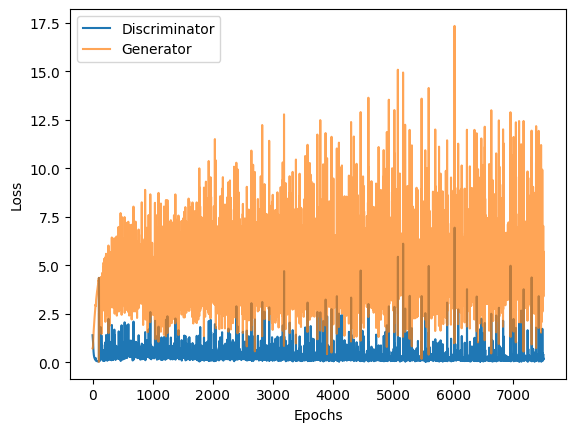

In [14]:
plt.plot(errorD)
plt.plot(errorG, alpha = 0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])